In [1]:
import datetime
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT_DIR = str(Path().resolve().parent)
sys.path.append(f"{ROOT_DIR}/src/")
plt.style.use(f'{ROOT_DIR}/notebooks/project.mplstyle')

# Running on Genomes

In [2]:
contig_filepath = f"{ROOT_DIR}/tests/test_data/GCA_000172155.1_ASM17215v1_genomic.fna.gz"
protein_filepath = f"{ROOT_DIR}/tests/test_data/GCA_000172155.1_ASM17215v1_protein.faa.gz"

## Prediction of growth conditions



In [3]:
from predict_physicochemistry import predict_physicochemistry

print(datetime.datetime.now())
predictions, genome_features = predict_physicochemistry(
        fna_path=contig_filepath,
        faa_path=protein_filepath,
        features_json=None,
        path_to_models=f"{ROOT_DIR}/models",
        #save_intermediate=False,
    )
print(datetime.datetime.now())

pd.DataFrame(predictions).T.sort_index()

2023-12-01 15:23:07.494603
2023-12-01 15:23:12.281961


,value,lower_ci,upper_ci,warning
oxygen,0.981243,NaN,NaN,NaN
ph_max,8.915613,NaN,NaN,NaN
ph_min,5.572296,NaN,NaN,NaN
ph_optimum,7.497270,NaN,NaN,NaN
salinity_max,7.258816,NaN,NaN,NaN
salinity_min,2.509730,NaN,NaN,NaN
salinity_optimum,4.434118,NaN,NaN,NaN
temperature_max,35.297075,NaN,NaN,NaN
temperature_min,15.892330,NaN,NaN,NaN
temperature_optimum,27.934813,NaN,NaN,NaN


## Measure Genome Features

### 1 Protein Sequence

In [4]:
from protein import Protein

sequence = ''.join("""MAAQDVKQQTPYRVIQLEWDAEKGERNEAVGNFDELVTHHPKSNSDAHLVDGKVVGGQAG
RTLGVVGGEIQEIEVSKAGKDYGLRPDQVLLKKDFMLEDSRLPSGPSSRSLDVPSPVAGV
VGTVNTSKGLVDVLDREGGDVILRVRHMSPLHVKAGDQVEYGQALGVQGKQATGAIHVHM
EVDSRYYQHYENYVGDLVSGRLSIDAERRDRGIEPRPFVDDGTIRIGGSSEMVQKVQQTL
NAEGYRGADNQPLQEDGVYRLSMQAAVINYQQAHGLSQTGDIDPATLQQIAPRTFPPELN
REDHNATPTYRNLQGAVPSQDPLHRQAEEDVRRLEQSLGRDYDDNSARLAASSAHLAKAN
GLTQIDHVVLSNQTAAVGKGENVFVVQGALDNPAHLMAHMKTSDAIAQPVEQSLSQLQTL
SETQRQQQAQQQSQQQDQQQLSAPQHRMV""".split('\n'))

protein = Protein(sequence)
protein.protein_metrics()

{'pi': 5.382106971740723,
 'zc': 0.19821826280623608,
 'nh2o': 0.07137639198218272,
 'gravy': -0.6514476614699332,
 'thermostable_freq': 0.356347438752784,
 'length': 449,
 'is_exported': False,
 'aa_M': 0.0200445434298441,
 'aa_A': 0.08463251670378619,
 'aa_Q': 0.10690423162583519,
 'aa_D': 0.0757238307349666,
 'aa_V': 0.0935412026726058,
 'aa_K': 0.0334075723830735,
 'aa_T': 0.0400890868596882,
 'aa_P': 0.0467706013363029,
 'aa_Y': 0.026726057906458798,
 'aa_R': 0.062360801781737196,
 'aa_I': 0.031180400890868598,
 'aa_L': 0.08240534521158129,
 'aa_E': 0.05790645879732739,
 'aa_W': 0.0022271714922048997,
 'aa_G': 0.08685968819599109,
 'aa_N': 0.035634743875278395,
 'aa_F': 0.011135857461024499,
 'aa_H': 0.035634743875278395,
 'aa_S': 0.066815144766147}

### 1 Signal Peptide Prediction

In [5]:
from signal_peptide import SignalPeptideHMM

partial_sequence = 'MNKTLIAAAVAGIVLLASNAQAQTVPEGYQLQQVLMMSRHNLRAPLANNG'

signal_peptide_model = SignalPeptideHMM()
is_exported, signal_end_index = signal_peptide_model.predict_signal_peptide(partial_sequence)
signal_peptide = partial_sequence[:signal_end_index+1]
is_exported, signal_peptide

(True, 'MNKTLIAAAVAGIVLLASNAQA')

In [9]:
formatted_sequence = signal_peptide_model._format_protein_sequence(partial_sequence)
pred_states, log_prob = signal_peptide_model._predict_hidden_states(formatted_sequence)
print(log_prob)
for aa, state in zip(partial_sequence[:len(formatted_sequence)], pred_states):
    print(aa,state)

-130.73482767354764
M B
N N3
K N2
T N1
L H
I H
A H
A H
A H
V H
A H
G H
I H
V H
L H
L H
A H
S C
N C
A C3
Q C2
A C1
Q M
T M
V M
P M
E M
G M
Y M
Q M
L M
Q M
Q M
V M
L M
M M
M M
S M
R M
H M
N M
L M
R M
A M
P M
L M
A M
N M
N M
G M


### 1 DNA Sequence


In [6]:
from dna import DNA

sequence = "GGATGGACGGAGGAATTCCTCAAGGAAGTCGGGCCCGCGCTGGTGGTACTCGGTCCAGGCTTCTTGCACGAAGAAGTCTCCGACCGCGCCTCTCTCCACCCTCCTGGCAAAATCGGCCAGTGACTTGATGCCGATGTGGTAGATGAAGCCGGTGTCGAGTACGCCCTTGGCGAAGGTCGGGTCCGCCAGCCTCTCGGGAAAATTTTCTTCGATGTTCAGATAGTAGCCGCGCATGCTGACGCCACGGCTATCTAAAGTGAACATTCCGTCCTTCAGAATGCAATCGGCATGGTGCCAAAATCCAGAGCCCACCGCGCTGGCAATCTTGTTGTCGTCAACTGCGTCGGATCGGACGAGGCACTTCGTGAACGGCGCCGGCAATTCGGACCGTCGAGTGTAATTACGGATTGCGGACCCAGACGGGCGCGTGGCGTGGCCGTTATGCCCAGCATTGACGGAGAACAGGTGGATTGCCCCCACTCCACCCGGAAAGCGTGAGATAAACTCTCGGATCGTGTCGTCGTTGCGCAGTAAAATAAATTCGTCAACATCGAGAAATATGTAATTACGGCTCAGATGTTTAAA"
dna = DNA(sequence)
dna.nucleotide_metrics()

{'nt_length': 585,
 'pur_pyr_transition_freq': 0.4897260273972603,
 'nt_C': 0.558974358974359,
 'nt_A': 0.441025641025641}

### All Protein and DNA Sequences

Note: It is expected and good to see NaN for many features because they cannot be computed by cellular localization.

In [7]:
from genome import Genome
from signal_peptide import SignalPeptideHMM


genome_calc = Genome(
    contig_filepath=contig_filepath, 
    protein_filepath=protein_filepath,
)

print(datetime.datetime.now())
genome_features = genome_calc.genome_metrics()
print(datetime.datetime.now())

2023-11-29 15:20:34.677249
2023-11-29 15:20:41.213365


In [8]:
genome_features.keys()

dict_keys(['all', 'extracellular_soluble', 'intracellular_soluble', 'membrane', 'diff_extra_intra'])

In [9]:
df_genome = pd.DataFrame(genome_features)
df_genome.head(30)

,all,extracellular_soluble,intracellular_soluble,membrane,diff_extra_intra
nt_length,8.220859e+06,NaN,NaN,NaN,NaN
pur_pyr_transition_freq,4.796972e-01,NaN,NaN,NaN,NaN
nt_C,6.031152e-01,NaN,NaN,NaN,NaN
nt_A,3.968848e-01,NaN,NaN,NaN,NaN
total_proteins,6.519000e+03,635.000000,5.336000e+03,548.000000,-4.701000e+03
total_protein_length,2.366909e+06,285520.000000,1.921398e+06,159991.000000,-1.635878e+06
pis_acidic,1.988035e-01,0.215748,2.113943e-01,0.056569,4.353729e-03
pis_neutral,4.914864e-01,0.615748,5.018741e-01,0.246350,1.138740e-01
pis_basic,3.097101e-01,0.168504,2.867316e-01,0.697080,-1.182277e-01
pis_3_4,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00


### All Proteins

In [10]:
protein_data = genome_calc.protein_data()
df_proteins = pd.DataFrame(protein_data).T
df_proteins

,pi,zc,nh2o,gravy,thermostable_freq,length,is_exported,aa_M,aa_S,aa_L,...,aa_C,aa_G,aa_A,aa_H,aa_E,aa_R,aa_Q,aa_N,aa_F,aa_W
ABIZ01000001.1_1,7.551992,-0.179457,0.014524,-0.33754,0.386581,626,False,0.025559,0.059105,0.089457,...,0.015974,0.08147,0.087859,0.017572,0.070288,0.063898,0.044728,0.031949,0.031949,0.01278
ABIZ01000001.1_2,11.364825,-0.744643,0.070964,0.251786,0.464286,56,False,0.017857,0.089286,0.125,...,0.017857,0.107143,0.089286,0.017857,0.017857,0.107143,NaN,0.035714,0.017857,0.035714
ABIZ01000001.1_3,6.49581,-0.276424,-0.020354,-0.144702,0.39404,302,False,0.023179,0.046358,0.112583,...,0.016556,0.092715,0.096026,0.043046,0.062914,0.05298,0.019868,0.039735,0.029801,0.013245
ABIZ01000001.1_4,6.166826,-0.120446,-0.054786,-0.380501,0.395543,359,False,0.022284,0.061281,0.094708,...,0.011142,0.075209,0.075209,0.038997,0.066852,0.064067,0.030641,0.050139,0.038997,0.011142
ABIZ01000001.1_5,5.399329,-0.281062,0.052735,-0.257522,0.411504,226,False,0.00885,0.070796,0.132743,...,0.022124,0.070796,0.110619,0.00885,0.070796,0.084071,0.053097,0.017699,0.030973,0.022124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ABIZ01000001.1_6515,9.24749,-0.947007,-0.111161,0.443796,0.394161,137,False,0.043796,0.051095,0.109489,...,0.007299,0.072993,0.153285,0.014599,0.021898,0.065693,0.029197,0.007299,0.058394,0.029197
ABIZ01000001.1_6516,8.159264,0.033143,0.083814,-0.695714,0.414286,70,False,0.014286,0.057143,0.114286,...,NaN,0.057143,0.057143,0.042857,0.1,0.071429,0.071429,0.057143,0.028571,NaN
ABIZ01000001.1_6517,5.395009,-0.4275,0.021831,-0.223529,0.433824,136,False,0.036765,0.051471,0.132353,...,0.029412,0.095588,0.066176,0.014706,0.080882,0.095588,0.051471,0.014706,0.029412,0.022059
ABIZ01000001.1_6518,4.872716,-0.37697,-0.011582,-0.013636,0.4,330,False,0.045455,0.060606,0.075758,...,0.024242,0.078788,0.087879,0.021212,0.075758,0.054545,0.018182,0.036364,0.036364,0.015152


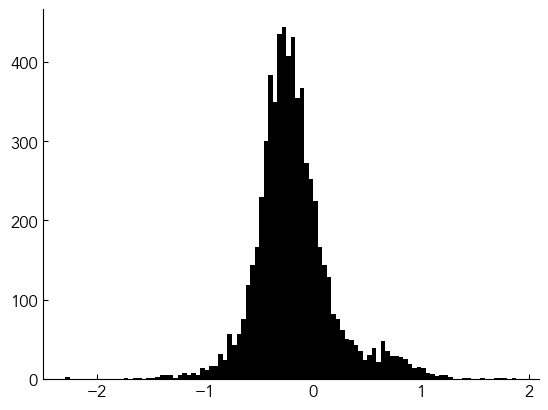

In [11]:
x = 'gravy'

X = df_proteins[x].values 

fig, ax = plt.subplots()
ax.hist(X, bins=100)
#ax.axvline(0.5)

plt.show()

# Model Training

## Balancing a Dataset by Taxonomy

In [12]:
import sys
sys.path.append('../src/')
with open('../tests/test_data/test_genome_accessions.txt', 'r') as fh:
    genomes = [line.strip().split('.')[0] for line in fh.readlines()]

In [13]:
from taxonomy import TaxonomyGTDB

taxonomy = TaxonomyGTDB()
len(taxonomy.taxonomy_dict.keys())

402709

In [14]:
accession = list(taxonomy.taxonomy_dict.keys())[0]
{accession : taxonomy.taxonomy_dict['GCA_019399425']}

{'GCA_000979555': ('Bacteria',
  'Bacillota',
  'Bacilli',
  'Lactobacillales',
  'Streptococcaceae',
  'Streptococcus',
  'Streptococcus pneumoniae')}

In [15]:
#taxonomy.taxonomy_dict[]
list(taxonomy.taxonomy_dict.keys())[190000]

'GCA_017565965'

In [16]:
from taxonomy import BalanceTaxa

taxonomy = TaxonomyGTDB()
balancer = BalanceTaxa(taxonomy=taxonomy)
balanced_genomes = balancer.balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.5,
    diversity_rank="species"
)
len(balanced_genomes) / len(genomes)

0.49996937588044343

## Partitioning (Splitting) a Dataset by Taxonomy

In [17]:
from taxonomy import PartitionTaxa

partitioner = PartitionTaxa(
    taxonomy=taxonomy,
    partition_rank='family',
    iteration_rank='phylum',
    diversity_rank='genus',
)

partitioned_genomes = partitioner.partition(balanced_genomes, partition_size=0.2)
nonpartitioned_genomes = set(balanced_genomes).difference(partitioned_genomes)
extended_partitioned_genomes = partitioner.find_relatives_of_partitioned_set_in_reference(partitioned_genomes)

print(len(partitioned_genomes) / len(balanced_genomes), len(nonpartitioned_genomes) / len(balanced_genomes))
print(len(partitioned_genomes), len(extended_partitioned_genomes))

0.20654171260565968 0.7934582873943403
1686 42041


In [18]:
# check for data leakage
partitioned_taxa = taxonomy.taxa_of_genomes(partitioned_genomes, partitioner.partition_rank)
nonpartitioned_taxa = taxonomy.taxa_of_genomes(nonpartitioned_genomes, partitioner.partition_rank)
assert len(partitioned_taxa.intersection(nonpartitioned_taxa)) == 0

# check partitioned genomes all present
len(set(partitioned_genomes).intersection(extended_partitioned_genomes)) == len(set(partitioned_genomes))
assert len(set(partitioned_genomes).difference(extended_partitioned_genomes)) == 0
print('Good!')

Good!


## Creating Cross-Validation Sets

In [19]:
# waiting for model training kit

## Balancing a Data Numerically

In [20]:
# waiting for model training kit

# Trait Data

## Download BacDive API Data

In [21]:
from model_training.download_training_data import QueryBacDive

credentials_filepath = f'../../.bacdive_credentials'

min_bacdive_id = 100
max_bacdive_id = 200
bacdive_dict = QueryBacDive(
            credentials_filepath=credentials_filepath,
            max_bacdive_id=int(max_bacdive_id),
            min_bacdive_id=int(min_bacdive_id),
        ).scrape_bacdive_api()

strain_ids = list(bacdive_dict.keys())
strain_data = bacdive_dict[strain_ids[0]]
strain_data.keys()

-- Authentication successful --


dict_keys(['General', 'Name and taxonomic classification', 'Morphology', 'Culture and growth conditions', 'Physiology and metabolism', 'Isolation, sampling and environmental information', 'Safety information', 'Sequence information', 'Genome-based predictions', 'External links', 'Reference'])

In [22]:
strain_data['General']

{'@ref': 3774,
 'BacDive-ID': 199,
 'DSM-Number': 10002,
 'keywords': ['genome sequence',
  '16S sequence',
  'Bacteria',
  'mesophilic',
  'animal pathogen'],
 'description': 'Arcanobacterium phocae M1590/94/3 is a mesophilic animal pathogen that was isolated from lung of common seal.',
 'NCBI tax id': {'NCBI tax id': 131112, 'Matching level': 'species'},
 'strain history': '<- G. Foster, M1590/94/3',
 'doi': '10.13145/bacdive199.20230509.8'}

## Parsing traits

In [23]:
from model_training.download_training_data import ComputeBacDiveTraits

strain_data = bacdive_dict[strain_ids[2]]
strain_traits = ComputeBacDiveTraits(strain_data).compute_trait_data()
strain_traits

{'ncbi_accession': 'GCA_900475915.1',
 'ncbi_taxid': 644284,
 'strain_id': 197,
 'species': 'Arcanobacterium haemolyticum',
 'ph_optimum': None,
 'ph_optimum_min': None,
 'ph_optimum_max': None,
 'temperature_optimum': 37.0,
 'salinity_optimum': None,
 'salinity_midpoint': None,
 'salinity_min': None,
 'salinity_max': None,
 'ph_min': None,
 'ph_max': None,
 'temperature_min': 37.0,
 'temperature_max': 37.0,
 'oxygen': 1,
 'use_ph_optimum': False,
 'use_temperature_optimum': False,
 'use_salinity_optimum': False,
 'use_ph_range': False,
 'use_temperature_range': False,
 'use_salinity_range': False,
 'use_oxygen': True,
 'aerobe': None,
 'anaerobe': 1,
 'microaerophile': None,
 'facultative anaerobe': 1,
 'obligate aerobe': None,
 'obligate anaerobe': None,
 'facultative aerobe': None,
 'aerotolerant': None,
 'microaerotolerant': None}